![Big Data University](https://ibm.box.com/shared/static/jvcqp2iy2jlx2b32rmzdt0tx8lvxgzkp.png)
# <center> Sequence classification with LSTM on MNIST</center>
<div class="alert alert-block alert-info">
<font size = 3><strong>In this notebook you will learn the How to use TensorFlow for create a Recurrent Neural Network</strong></font>
<br>    
- <a href="#intro">Introduction</a>
<br>
- <p><a href="#arch">Architectures</a></p>
    - <a href="#lstm">Long Short-Term Memory Model (LSTM)</a>

- <p><a href="#build">Building a LSTM with TensorFlow</a></p>
</div>
----------------

## <a id="intro"/> Introduction
Recurrent Neural Networks are Deep Learning models with simple structures and a feedback mechanism builted-in, or in different words, the output of a layer is added to the next input and fed back to the same layer.

The Recurrent Neural Network is a specialized type of Neural Network that solves the issue of **maintaining context for Sequential data** -- such as Weather data, Stocks, Genes, etc. At each iterative step, the processing unit takes in an input and the current state of the network, and produces an output and a new state that is **re-fed into the network**.

However, **this model has some problems**. It's very computationally expensive to maintain the state for a large amount of units, even more so over a long amount of time. Additionally, Recurrent Networks are very sensitive to changes in their parameters. As such, they are prone to different problems with their Gradient Descent optimizer -- they either grow exponentially (Exploding Gradient) or drop down to near zero and stabilize (Vanishing Gradient), both problems that greatly harm a model's learning capability.

To solve these problems, Hochreiter and Schmidhuber published a paper in 1997 describing a way to keep information over long periods of time and additionally solve the oversensitivity to parameter changes, i.e., make backpropagating through the Recurrent Networks more viable.

(In this notebook, we will cover only LSTM and its implementation using TensorFlow)

## <a id="arch"/>Architectures
- Fully Recurrent Network
- Recursive Neural Networks
- Hopfield Networks
- Elman Networks and Jordan Networks
- Echo State Networks
- Neural history compressor
- **The Long Short-Term Memory Model (LSTM)**

<img src="https://ibm.box.com/shared/static/v7p90neiaqghmpwawpiecmz9n7080m59.png" alt="Representation of a Recurrent Neural Network" width=80%>

##  <a id="lstm"/>LSTM
LSTM is one of the proposed solutions or upgrades to the **Recurrent Neural Network model**. 

It is an abstraction of how computer memory works. It is "bundled" with whatever processing unit is implemented in the Recurrent Network, although outside of its flow, and is responsible for keeping, reading, and outputting information for the model. The way it works is simple: you have a linear unit, which is the information cell itself, surrounded by three logistic gates responsible for maintaining the data. One gate is for inputting data into the information cell, one is for outputting data from the input cell, and the last one is to keep or forget data depending on the needs of the network.

Thanks to that, it not only solves the problem of keeping states, because the network can choose to forget data whenever information is not needed, it also solves the gradient problems, since the Logistic Gates have a very nice derivative.

### Long Short-Term Memory Architecture

As seen before, the Long Short-Term Memory is composed of a linear unit surrounded by three logistic gates. The name for these gates vary from place to place, but the most usual names for them are:
- the "Input" or "Write" Gate, which handles the writing of data into the information cell, 
- the "Output" or "Read" Gate, which handles the sending of data back onto the Recurrent Network, and 
- the "Keep" or "Forget" Gate, which handles the maintaining and modification of the data stored in the information cell.

<img src=https://ibm.box.com/shared/static/zx10duv5egw0baw6gh2hzsgr8ex45gsg.png width="720"/>
<center>*Diagram of the Long Short-Term Memory Unit*</center>

The three gates are the centerpiece of the LSTM unit. The gates, when activated by the network, perform their respective functions. For example, the Input Gate will write whatever data it is passed onto the information cell, the Output Gate will return whatever data is in the information cell, and the Keep Gate will maintain the data in the information cell. These gates are analog and multiplicative, and as such, can modify the data based on the signal they are sent.

---

## <a id="build"/> Building a LSTM with TensorFlow

#### LSTM for Classification
Although RNN is mostly used to model sequences and predict sequential data, we can still classify images using a LSTM network. If we consider every image row as a sequence of pixels, we can feed a LSTM network for classification. Lets use the famous MNIST dataset here. Because MNIST image shape is 28*28px, we will then handle 28 sequences of 28 steps for every sample.

#### MNIST Dataset

Tensor flow already provides **helper functions** to download and process the MNIST dataset.

In [23]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../data/MNIST/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../../data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../../data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../data/MNIST/t10k-labels-idx1-ubyte.gz


The function **`input_data.read_data_sets(...)`** loads the entire dataset and returns an object **`tensorflow.contrib.learn.python.learn.datasets.mnist.DataSets`**


The argument **(`one_hot=False`)** creates the label arrays as 10-dimensional binary vectors (only zeros and ones), in which the index cell for the number one, is the class label.

In [4]:
trainimgs = mnist.train.images
trainlabels = mnist.train.labels
testimgs = mnist.test.images
testlabels = mnist.test.labels 

ntrain = trainimgs.shape[0]
ntest = testimgs.shape[0]
dim = trainimgs.shape[1]
nclasses = trainlabels.shape[1]
print("Train Images: ", trainimgs.shape)
print("Train Labels  ", trainlabels.shape)
print()
print("Test Images:  " , testimgs.shape)
print("Test Labels:  ", testlabels.shape)

Train Images:  (55000, 784)
Train Labels   (55000, 10)

Test Images:   (10000, 784)
Test Labels:   (10000, 10)


### Let's get one sample, just to understand the structure of MNIST dataset 

The next code snippet prints the **label vector** (one_hot format), **the class** and actual sample formatted as **image**:

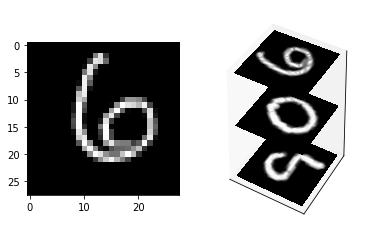

Sample: 100 - Class: [6] - Label Vector: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.] 
Sample: 101 - Class: [0] - Label Vector: [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 
Sample: 104 - Class: [9] - Label Vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.] 


In [6]:
samplesIdx = [100, 101, 104]  #<-- You can change these numbers here to see other samples

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow(testimgs[samplesIdx[0]].reshape([28,28]), cmap='gray')


xx, yy = np.meshgrid(np.linspace(0,28,28), np.linspace(0,28,28))
X =  xx ; Y =  yy
Z =  100*np.ones(X.shape)

img = testimgs[77].reshape([28,28])
ax = fig.add_subplot(122, projection='3d')
ax.set_zlim((0,200))


offset=200
for i in samplesIdx:
    img = testimgs[i].reshape([28,28]).transpose()
    ax.contourf(X, Y, img, 200, zdir='z', offset=offset, cmap="gray")
    offset -= 100

    ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()


for i in samplesIdx:
    print("Sample: {0} - Class: {1} - Label Vector: {2} ".format(i, np.nonzero(testlabels[i])[0], testlabels[i]))

---
### Let's Understand the parameters, inputs and outputs

We will treat the MNIST image $\in \mathcal{R}^{28 \times 28}$ as $28$ sequences of a vector $\mathbf{x} \in \mathcal{R}^{28}$. 

#### Our simple RNN consists of  
1. One input layer which converts a $28$ dimensional input to an $128$ dimensional hidden layer, 
2. One intermediate recurrent neural network (LSTM) 
3. One output layer which converts an $128$ dimensional output of the LSTM to $10$ dimensional output indicating a class label. 

In [24]:
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)


learning_rate = 0.001
training_iters = 100000
batch_size = 100
display_step = 10


#### Construct a Recurrent Neural Network

In [6]:
x = tf.placeholder(dtype="float", shape=[None, n_steps, n_input], name="x")
y = tf.placeholder(dtype="float", shape=[None, n_classes], name="y")

In [7]:
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}

The input should be a Tensor of shape: [batch_size, max_time, ...], in our case it would be (?, 28, 28)

In [8]:
# Define a lstm cell with tensorflow
lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)

#initial state
#initial_state = (tf.zeros([1,n_hidden]),)*2

In [9]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input) [100x28x28]

    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
   

    # Get lstm cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cell, inputs=x, dtype=tf.float32)

    # Get lstm cell output
    #outputs, states = lstm_cell(x , initial_state)
    
    # The output of the rnn would be a [100x28x128] matrix. we use the linear activation to map it to a [?x10 matrix]
    # Linear activation, using rnn inner loop last output
    # output [100x128] x  weight [128, 10] + []
    output = tf.reshape(tf.split(outputs, 28, axis=1, num=None, name='split')[-1],[-1,128])
    return tf.matmul(output, weights['out']) + biases['out']

In [10]:
with tf.variable_scope('forward3'):
    pred = RNN(x, weights, biases)

__labels__ and __logits__ should be tensors of shape [100x10] 

In [11]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [12]:
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [13]:
accuracy_v2 = tf.contrib.metrics.accuracy(
    labels=tf.arg_max(y, dimension=1), 
    predictions=tf.arg_max(pred, dimension=1)
)

Just recall that we will treat the MNIST image $\in \mathcal{R}^{28 \times 28}$ as $28$ sequences of a vector $\mathbf{x} \in \mathcal{R}^{28}$. 

In [14]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

In [15]:
sess.run(init)
step = 1
# Keep training until reach max iterations
while step * batch_size < training_iters:

    # We will read a batch of 100 images [100 x 784] as batch_x
    # batch_y is a matrix of [100x10]
    batch_x, batch_y = mnist.train.next_batch(batch_size)

    # We consider each row of the image as one sequence
    # Reshape data to get 28 seq of 28 elements, so that, batxh_x is [100x28x28]
    batch_x = batch_x.reshape((batch_size, n_steps, n_input))


    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})


    if step % display_step == 0:
        # Calculate batch accuracy
        acc, acc2 = sess.run([accuracy, accuracy_v2], feed_dict={x: batch_x, y: batch_y})
        # Calculate batch loss
        loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        print("({} / {})    Minibatch loss={:.6f}    Accuracy={:.5f}    Accuracy (tf)={:.5f}".format(
                step*batch_size,
                training_iters,
                loss,
                acc,
                acc2
            ))
    step += 1
print("Optimization Finished!")

(1000 / 100000)    Minibatch loss=1.850881    Accuracy=0.43000    Accuracy (tf)=0.43000
(2000 / 100000)    Minibatch loss=1.456735    Accuracy=0.55000    Accuracy (tf)=0.55000
(3000 / 100000)    Minibatch loss=1.155387    Accuracy=0.59000    Accuracy (tf)=0.59000
(4000 / 100000)    Minibatch loss=1.249778    Accuracy=0.54000    Accuracy (tf)=0.54000
(5000 / 100000)    Minibatch loss=1.142365    Accuracy=0.64000    Accuracy (tf)=0.64000
(6000 / 100000)    Minibatch loss=0.885371    Accuracy=0.74000    Accuracy (tf)=0.74000
(7000 / 100000)    Minibatch loss=0.507802    Accuracy=0.81000    Accuracy (tf)=0.81000
(8000 / 100000)    Minibatch loss=0.628446    Accuracy=0.75000    Accuracy (tf)=0.75000
(9000 / 100000)    Minibatch loss=0.534296    Accuracy=0.80000    Accuracy (tf)=0.80000
(10000 / 100000)    Minibatch loss=0.328939    Accuracy=0.91000    Accuracy (tf)=0.91000
(11000 / 100000)    Minibatch loss=0.335713    Accuracy=0.90000    Accuracy (tf)=0.90000
(12000 / 100000)    Minibatch 

(94000 / 100000)    Minibatch loss=0.076773    Accuracy=0.97000    Accuracy (tf)=0.97000
(95000 / 100000)    Minibatch loss=0.181465    Accuracy=0.94000    Accuracy (tf)=0.94000
(96000 / 100000)    Minibatch loss=0.119581    Accuracy=0.96000    Accuracy (tf)=0.96000
(97000 / 100000)    Minibatch loss=0.103791    Accuracy=0.97000    Accuracy (tf)=0.97000
(98000 / 100000)    Minibatch loss=0.057231    Accuracy=0.98000    Accuracy (tf)=0.98000
(99000 / 100000)    Minibatch loss=0.125223    Accuracy=0.95000    Accuracy (tf)=0.95000
Optimization Finished!


In [16]:
# Calculate accuracy for the whole test set
test_data = mnist.test.images.reshape((-1, n_steps, n_input))
test_label = mnist.test.labels
print("Testing Accuracy: {:.3%}".format(sess.run(accuracy, feed_dict={x: test_data, y: test_label})))

Testing Accuracy: 96.670%


In [17]:
sess.close()



Created by <a href="https://br.linkedin.com/in/walter-gomes-de-amorim-junior-624726121">Walter Gomes de Amorim Junior</a> ,  <a href = "https://linkedin.com/in/saeedaghabozorgi"> Saeed Aghabozorgi </a></h4>  

